In [56]:
#importing libraries
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [57]:
#read csv file
df = pd.read_csv('/content/sample_data/Quality Prediction.csv', skiprows=1)
df.head()

,VariantID,Variant_Change,Mono_Identity,DateTimeCreated,Mono_MM_Delay (s),A_Mono_MM_Duration (s),B_Mono_MM_Duration (s),Wrap_Delay (s),A_Wrapping_Duration (s),B_Wrapping_Duration (s),Press_Delay (s),A_Pressing_Duration (s),B_Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),CycleTime (s),Downtime (s),ShutDown (s),A_MonoMM_Dia,B_MonoMM_Dia,A_MatWeight,B_MatWeight,A_GBD_MM_Gap,B_GBD_MM_Gap,A_GBD_Diameter,B_GBD_Diameter,A_GBD,B_GBD,A_PressSB,B_PressSB,A_PressDispl,B_PressDispl,A_PForce,B_PForce,A_MonoMM_Result,B_MonoMM_Result,A_GBD_Result,B_GBD_Result,A_Press_Result,B_Press_Result,A_Marking_Result,B_Marking_Result,ShiftNumber,Shift_Status,Final_Result
0,28,1,Double,8/7/2021 7:33:38,1,0.0,0.0,364,0.0,0.0,2,0.0,0.0,0.0,123.0,NaN,0,0,267.111,266.777,616.5,478.4,616.5,478.4,284.620,284.979,0.665,0.666,0.35,0.35,871.674,874.806,5076,16.0,1,1.0,1.0,1.0,1,1.0,1.0,1.0,1,Shift_Change,1
1,28,0,Double,8/7/2021 7:46:45,1,787.0,787.0,42,812.0,406.0,2,448.0,448.0,510.0,186.0,511.0,449,0,267.097,266.452,627.3,476.9,627.3,476.9,284.849,284.593,0.666,0.667,0.35,0.35,872.457,874.433,4870,6.0,1,1.0,1.0,1.0,1,1.0,1.0,1.0,1,Same_Shift,1
2,28,0,Double,8/7/2021 7:48:58,60,133.0,72.0,61,93.0,74.0,1,94.0,93.0,36.0,127.0,35.0,0,0,267.059,266.826,655.3,487.8,655.3,487.8,285.396,285.283,0.669,0.668,0.35,0.35,873.022,874.042,5044,30.0,1,1.0,1.0,1.0,1,1.0,1.0,1.0,1,Same_Shift,1
3,28,0,Double,8/7/2021 7:49:31,32,33.0,61.0,3,35.0,93.0,2,34.0,35.0,35.0,128.0,35.0,0,0,267.075,266.849,620.7,457.2,620.7,457.2,284.695,284.404,0.665,0.665,0.35,0.35,872.577,873.295,5474,8.0,1,1.0,1.0,1.0,1,1.0,1.0,1.0,1,Same_Shift,1
4,28,0,Double,8/7/2021 7:50:06,1,35.0,68.0,3,35.0,35.0,2,35.0,35.0,37.0,130.0,37.0,0,0,267.072,266.494,608.0,467.7,608.0,467.7,284.402,284.372,0.664,0.665,0.35,0.35,872.728,874.141,4900,16.0,1,1.0,1.0,1.0,1,1.0,1.0,1.0,1,Same_Shift,1


In [58]:
#checking Nan values
df.isna().any().sum()

25

In [59]:
#drop Nan values
df = df.dropna()
df_final = df.copy()

#dropping datetime as we dont need it
df_final.drop(['DateTimeCreated'], axis = 1, inplace = True)
df_final = pd.get_dummies(df_final, columns=['Mono_Identity', 'Shift_Status'], drop_first=True)

In [60]:
#describe stats of dataset
df_final.describe()

,VariantID,Variant_Change,Mono_MM_Delay (s),A_Mono_MM_Duration (s),B_Mono_MM_Duration (s),Wrap_Delay (s),A_Wrapping_Duration (s),B_Wrapping_Duration (s),Press_Delay (s),A_Pressing_Duration (s),B_Pressing_Duration (s),GBD_MM Duration (s),OperationTime (s),CycleTime (s),Downtime (s),ShutDown (s),A_MonoMM_Dia,B_MonoMM_Dia,A_MatWeight,B_MatWeight,A_GBD_MM_Gap,B_GBD_MM_Gap,A_GBD_Diameter,B_GBD_Diameter,A_GBD,B_GBD,A_PressSB,B_PressSB,A_PressDispl,B_PressDispl,A_PForce,B_PForce,A_MonoMM_Result,B_MonoMM_Result,A_GBD_Result,B_GBD_Result,A_Press_Result,B_Press_Result,A_Marking_Result,B_Marking_Result,ShiftNumber,Final_Result,Shift_Status_Shift_Change
count,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.0,21707.0,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000,21707.000000
mean,16.659004,0.003501,64.820427,309.410789,309.443497,31.198001,309.298936,359.282029,2.005851,309.308103,359.284056,309.609020,216.428203,309.588934,258.661584,170.293408,262.869815,262.464629,582.755051,404.415944,582.755051,404.415944,280.063268,279.706141,0.657848,0.655930,0.607546,0.607546,863.852756,889.682324,2305.511033,1461.306767,1.0,1.0,0.998157,0.998111,0.999724,0.999908,0.991570,0.991570,1.463261,0.991570,0.004791
std,9.552635,0.059068,213.854016,4530.430329,4531.763320,153.378024,4529.169425,5163.897227,0.852156,4538.347670,5169.894689,4538.498229,467.875071,4538.829485,4538.148133,4501.166075,11.864128,11.848679,90.915466,62.724015,90.915466,62.724015,12.948190,12.889446,0.024188,0.022084,0.268248,0.268248,29.629482,26.259635,1093.524388,1748.909155,0.0,0.0,0.042888,0.043420,0.016624,0.009599,0.091432,0.091432,0.536662,0.091432,0.069053
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,31.000000,1.000000,23.000000,25.000000,1.000000,111.000000,26.000000,0.000000,0.000000,228.513000,228.161000,305.100000,217.300000,305.100000,217.300000,242.241000,242.017000,0.361000,0.376000,0.300000,0.300000,742.803000,759.300000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,7.000000,0.000000,1.000000,35.000000,36.000000,2.000000,35.000000,35.000000,2.000000,35.000000,35.000000,36.000000,130.000000,36.000000,0.000000,0.000000,266.903000,266.497000,588.800000,344.800000,588.800000,344.800000,284.094000,283.636000,0.644000,0.643000,0.350000,0.350000,871.630000,873.446000,1712.000000,14.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,17.000000,0.000000,19.000000,39.000000,41.000000,3.000000,36.000000,37.000000,2.000000,37.000000,37.000000,39.000000,138.000000,39.000000,0.000000,0.000000,267.022000,266.585000,601.800000,430.200000,601.800000,430.200000,284.432000,284.045000,0.660000,0.660000,0.500000,0.500000,872.999000,875.349000,2314.000000,626.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,27.000000,0.000000,70.000000,94.000000,94.000000,6.000000,96.000000,96.000000,2.000000,95.000000,95.000000,95.000000,200.000000,96.000000,0.000000,0.000000,267.091000,266.674000,627.700000,450.000000,627.700000,450.000000,284.847000,284.563000,0.667000,0.666000,0.900000,0.900000,873.759000,896.242000,2899.000000,2624.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,37.000000,1.000000,9786.000000,328036.000000,328363.000000,9772.000000,328036.000000,328345.000000,34.000000,328345.000000,328345.000000,328365.000000,27091.000000,328391.000000,328329.000000,328329.000000,267.520000,267.337000,677.900000,501.500000,677.900000,501.

In [61]:
X = df_final.drop(['Final_Result'], axis = 1)
y = df_final.Final_Result

In [62]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24, stratify = X.VariantID)

In [63]:
X_train.shape, y_train.shape

((17365, 42), (17365,))

In [64]:
X_test.shape, y_test.shape

((4342, 42), (4342,))

In [65]:
#normalizing the dataset
Std_scaler = StandardScaler()
X_train_scaled = Std_scaler.fit_transform(X_train)
X_test_scaled = Std_scaler.transform(X_test)

In [66]:
#list of classifiers
Classifier_list = [
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    DecisionTreeClassifier()
]

In [67]:
# score of all the classifiers
for model in Classifier_list:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_scaled)
    print(model)
    print("f1-score:", f1_score(y_test, y_pred, average='weighted'))
    print()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


GradientBoostingClassifier()
f1-score: 0.00014400205158218704

RandomForestClassifier()
f1-score: 0.00014400205158218704

DecisionTreeClassifier()
f1-score: 0.00014400205158218704



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [68]:
# hyperparameter tuning
parameters_rfg = { 'n_estimators' : [int(x) for x in np.linspace(start = 30, stop = 300, num = 10)],
              'max_depth' : [int(x) for x in np.linspace(10, 50, num = 10)],
              'max_features' : ['auto', 'sqrt'],
              'min_samples_split' : [2, 5, 7],
              'min_samples_leaf' : [1, 2, 4]
             }

In [70]:
# fitting the model to data
Rf_reg = RandomForestClassifier()

RF_reg_cv = RandomizedSearchCV(estimator = Rf_reg, 
                         param_distributions= parameters_rfg,
                         cv = 3, verbose =2, random_state = 24, n_jobs = -1)
RF_reg_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [30, 60, 90, 120, 150,
                                                         180, 210, 240, 270,
                                                         300]},
                   random_state=24, verbose=2)

In [71]:
#best parameter after hyperparameter tuning
RF_reg_cv.best_params_

{'max_depth': 18,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 270}

In [72]:
RF_reg_cv

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [30, 60, 90, 120, 150,
                                                         180, 210, 240, 270,
                                                         300]},
                   random_state=24, verbose=2)

In [73]:
#fit the best model
best_model = RF_reg_cv.best_estimator_
preds_Rf = best_model.predict(X_test_scaled)

In [74]:
#score of the model
print("f1-score:", f1_score(y_test, preds_Rf, average='weighted'))

f1-score: 1.0


## Neural Network

In [75]:
#linear activation
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (X_train_scaled.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#using adam as the optimizer
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                2752      
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,809
Trainable params: 3,809
Non-trainable params: 0
_________________________________________________________________


In [76]:
#training the model
model.fit(X_train_scaled, y_train, epochs = 10, verbose = 2)

Epoch 1/10
543/543 - 1s - loss: 0.0394 - 1s/epoch - 3ms/step
Epoch 2/10
543/543 - 1s - loss: 3.6146e-04 - 742ms/epoch - 1ms/step
Epoch 3/10
543/543 - 1s - loss: 8.4640e-05 - 850ms/epoch - 2ms/step
Epoch 4/10
543/543 - 1s - loss: 3.9687e-05 - 799ms/epoch - 1ms/step
Epoch 5/10
543/543 - 1s - loss: 2.2149e-05 - 709ms/epoch - 1ms/step
Epoch 6/10
543/543 - 1s - loss: 1.3515e-05 - 738ms/epoch - 1ms/step
Epoch 7/10
543/543 - 1s - loss: 8.7144e-06 - 735ms/epoch - 1ms/step
Epoch 8/10
543/543 - 1s - loss: 5.8249e-06 - 691ms/epoch - 1ms/step
Epoch 9/10
543/543 - 1s - loss: 3.9891e-06 - 1s/epoch - 2ms/step
Epoch 10/10
543/543 - 1s - loss: 2.7833e-06 - 639ms/epoch - 1ms/step


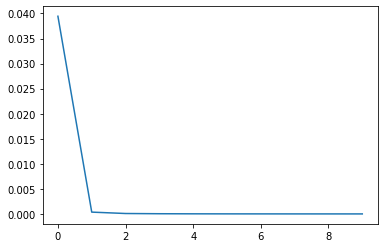

In [77]:
#plot model graph
plt.plot(model.history.history['loss'])

In [78]:
#predictions
scores = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Loss on Test-set : {np.round(scores, 6)}')

Loss on Test-set : 2e-06


In [79]:
#model score
print("f1-score : ", f1_score(y_test, [round(i[0]) for i in model.predict(X_test_scaled).tolist()]))

f1-score :  1.0
